In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import cv2

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from keras.layers import Conv2D,Flatten,Dropout,Dense,Activation,BatchNormalization,Input


2024-03-14 09:21:38.265920: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 09:21:38.266045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 09:21:38.406553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#Load train, val and test set
train_dir = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
test_dir = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test'
val_dir = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

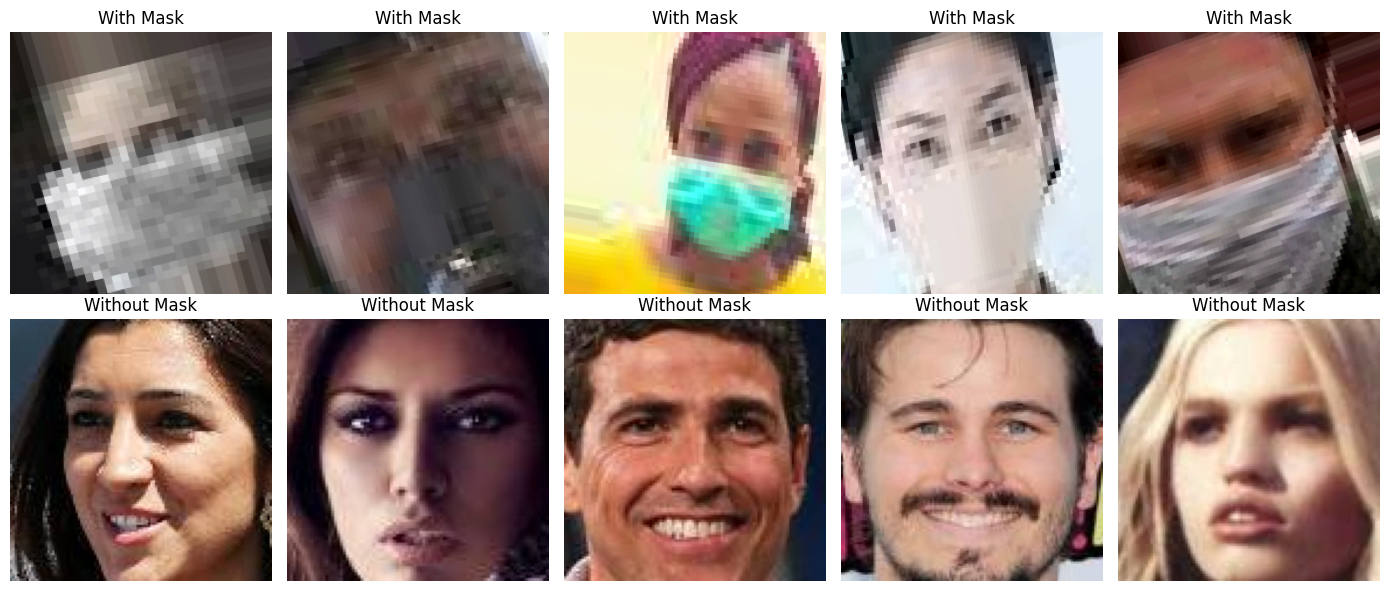

In [4]:
mask_path = train_dir + '/WithMask'
without_mask_path = train_dir + '/WithoutMask'

mask_images = [os.path.join(mask_path, file) for file in os.listdir(mask_path)[:5]]
without_mask_images = [os.path.join(without_mask_path, file) for file in os.listdir(without_mask_path)[:5]]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 6))

for i, path in enumerate(mask_images):
    img = mpimg.imread(path)
    axes[0, i].imshow(img)
    axes[0, i].set_title('With Mask')
    axes[0, i].axis('off')

for i, path in enumerate(without_mask_images):
    img = mpimg.imread(path)
    axes[1, i].imshow(img)
    axes[1, i].set_title('Without Mask')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [5]:
# define the 2 classes
classes = ['WithMask', 'WithoutMask']

# initialize empty lists to store images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []
val_images = []
val_labels = []

# desired dimension for images
desired_size = (128, 128)

for c in classes:
    train_path = os.path.join(train_dir, c)
    val_path = os.path.join(val_dir, c)
    test_path = os.path.join(test_dir, c)

    for file in os.listdir(train_path):
        if file.endswith('.png'):
            img_path = os.path.join(train_path, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, desired_size)  # reshape the image with desired dimension
            train_images.append(img.flatten())  # flatten the image and add it to the list of images
            train_labels.append(c)
        
    for file in os.listdir(val_path):
        if file.endswith('.png'):
            img_path = os.path.join(val_path, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, desired_size)
            val_images.append(img.flatten())
            val_labels.append(c)        

    for file in os.listdir(test_path):
        if file.endswith('.png'):
            img_path = os.path.join(test_path, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, desired_size)
            test_images.append(img.flatten())
            test_labels.append(c)  
            
            
# convert lists in numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)

In [6]:
# Reshape the dataframe
train_images = train_images.reshape(-1, 128, 128, 3)
val_images = val_images.reshape(-1, 128, 128, 3)
test_images = test_images.reshape(-1, 128, 128, 3)

In [7]:
# Print arrays shape
print(train_images.shape)
print(train_labels.shape)
print(val_images.shape)
print(val_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(10000, 128, 128, 3)
(10000,)
(800, 128, 128, 3)
(800,)
(992, 128, 128, 3)
(992,)


In [8]:
# create label encoder 
label_encoder = LabelEncoder()

# Encode labels in integers
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

# Convert labels to categorical format using one-hot encoding
train_labels = tfk.utils.to_categorical(train_labels)
val_labels = tfk.utils.to_categorical(val_labels)
test_labels = tfk.utils.to_categorical(test_labels)

In [9]:
# Define key model parameters
input_shape = train_images.shape[1:]  # Input shape for the model
output_shape = train_labels.shape[1]  # Output shape for the model
batch_size = 32                       # Batch size for training
epochs = 20                           # Number of training epochs
dropout_rate = 0.4                    # Dropout rate for the model
learning_rate = 1e-3                  # Learning rate for the optimizer

In [10]:
# Definisci le trasformazioni che desideri applicare alle immagini
datagen = ImageDataGenerator(
    rotation_range=10,      # Rotazione casuale dell'immagine fino a 20 gradi
    zoom_range=0.2,         # Ingrandimento casuale dell'immagine fino al 20%
    horizontal_flip=True,   # Ribaltamento casuale dell'immagine orizzontalmente
    vertical_flip=True,     # Ribaltamento casuale dell'immagine verticalmente
    #brightness_range=[0.8, 1.2],  # Modifica casuale della luminosità dell'immagine
)

In [11]:
supernet = tfk.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling=None,
)

supernet.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
input_layer = tfkl.Input(shape=input_shape, name='input_layer')

x = supernet(input_layer, training=False)

x =tfkl.Flatten(name='Flattening')(x)

'''x = tfkl.Dropout(dropout_rate)(x)

x = tfkl.Dense(
    units=512,
    activation=tfkl.LeakyReLU(alpha=0.2),  # Usando Leaky ReLU
    name='dense1'
)(x)

x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(dropout_rate)(x)

x = tfkl.Dense(
    units=128,
    activation=tfkl.LeakyReLU(alpha=0.2),  # Usando Leaky ReLU
    name='dense2'
)(x)


x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(dropout_rate)(x)
'''
output_layer = tfkl.Dense(units=2, activation='sigmoid',name='Output')(x)

In [13]:
model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'VGG19')

In [14]:
# compile the model
mtr = ['accuracy']
model.compile(optimizer="adam",loss="binary_crossentropy",metrics = mtr)

In [15]:
patience = 50

early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, mode='auto')
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=patience, factor=0.999, mode='min', min_lr=1e-5)

callbacks = [
    early_stopping,
    lr_scheduler
]

In [16]:
history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_images, val_labels),
    callbacks=callbacks
).history

Epoch 1/20


2024-03-14 09:24:27.330951: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.34782, expected 3.51669
2024-03-14 09:24:27.331011: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.71977, expected 5.88864
2024-03-14 09:24:27.331020: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.95696, expected 6.12583
2024-03-14 09:24:27.331028: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.48105, expected 5.64992
2024-03-14 09:24:27.331036: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.32797, expected 4.49684
2024-03-14 09:24:27.331043: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.7497, expected 4.91857
2024-03-14 09:24:27.331051: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.01592, expected 5.18479
2024-03-14 09:24:27.331059: E external/local_xla/xla/ser

  5/313 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7456 - loss: 11.1300

I0000 00:00:1710408274.072394      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9661 - loss: 1.3882

2024-03-14 09:24:42.853486: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12288: 3.16341, expected 2.72723
2024-03-14 09:24:42.853567: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12416: 3.00427, expected 2.56808
2024-03-14 09:24:42.853594: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16384: 4.67983, expected 3.93377
2024-03-14 09:24:42.853618: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16385: 6.45374, expected 5.70769
2024-03-14 09:24:42.853627: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16386: 6.1411, expected 5.39504
2024-03-14 09:24:42.853635: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16387: 5.93718, expected 5.19113
2024-03-14 09:24:42.853643: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16388: 4.45506, expected 3.70901
2024-03-14 09:24:42.853651: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.9663 - loss: 1.3813 - val_accuracy: 0.9950 - val_loss: 0.2897 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9976 - loss: 0.1286 - val_accuracy: 0.9962 - val_loss: 0.3135 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9981 - loss: 0.0995 - val_accuracy: 0.9975 - val_loss: 0.0992 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9995 - loss: 0.0236 - val_accuracy: 0.9962 - val_loss: 0.2519 - learning_rate: 0.0010
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9992 - loss: 0.0464 - val_accuracy: 0.9975 - val_loss: 0.1456 - learning_rate: 0.0010
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9997 - loss: 0.0248 - val_accuracy: 0.9962 - val_loss: 0.2032 - learning_rate: 0.0010
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 1.0000 - loss: 0.0092 - val

In [17]:
# Save the trained model
model.save('/kaggle/working/vgg19.keras')

Input image


2024-03-14 09:27:40.586835: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 3.66788, expected 2.82077
2024-03-14 09:27:40.586904: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32769: 5.27059, expected 4.42348
2024-03-14 09:27:40.586925: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32770: 5.00058, expected 4.15347
2024-03-14 09:27:40.586933: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32771: 4.72297, expected 3.87586
2024-03-14 09:27:40.586941: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32772: 4.5861, expected 3.73899
2024-03-14 09:27:40.586949: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32773: 4.17555, expected 3.32844
2024-03-14 09:27:40.586956: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32774: 3.43326, expected 2.58615
2024-03-14 09:27:40.586964: 

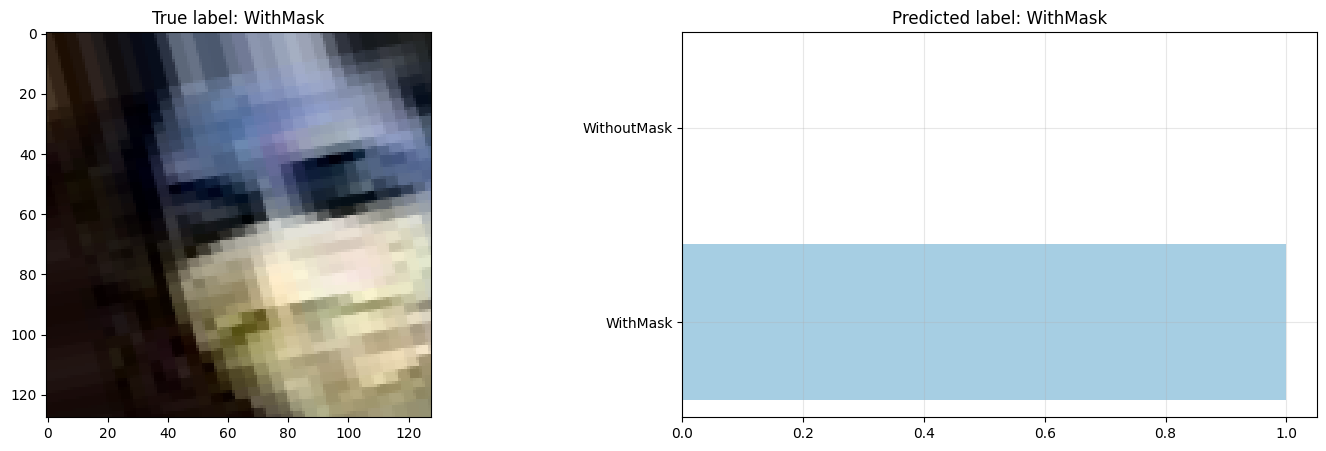

In [18]:
# Choose a random image for visualization
image = np.random.randint(0, len(test_images))

# Display the input image, true label, and predicted label
print('Input image')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 5)

# Riporta i valori dei pixel alla scala originale [0, 255]
input_image = (test_images[image])

ax1.imshow(input_image)
ax1.set_title('True label: ' + classes[np.argmax(test_labels[image])])  # Accesso diretto all'etichetta

prediction = model.predict(np.expand_dims(test_images[image], axis=0), verbose=0)

ax2.barh(classes, np.squeeze(prediction), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + classes[np.argmax(prediction)])  # Utilizza l'etichetta prevista
ax2.grid(alpha=0.3)
plt.show()


In [19]:
# Predict labels for the entire test set
predictions = model.predict(test_images, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (992, 2)


Accuracy: 0.996
Precision: 0.9959
Recall: 0.996
F1: 0.996


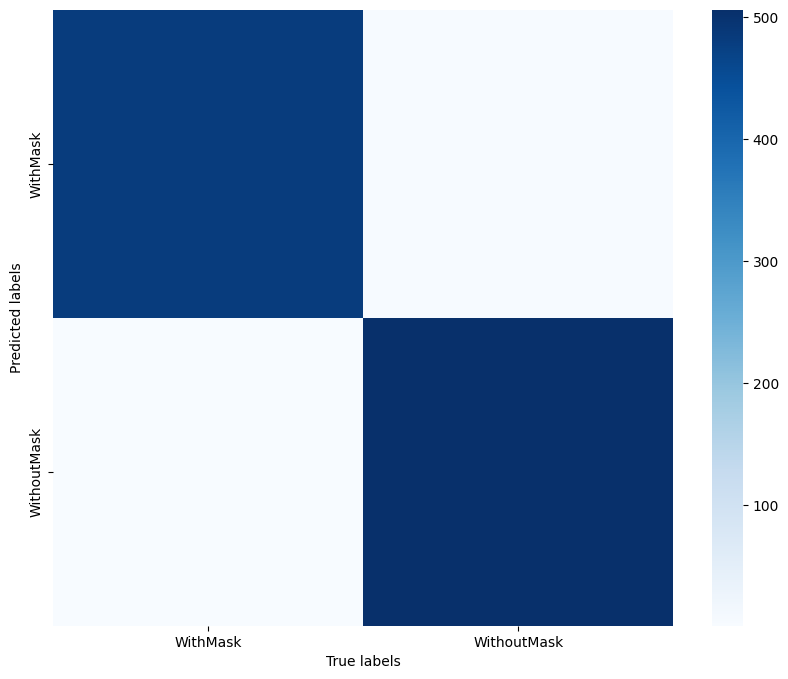

In [20]:
cm = confusion_matrix(np.argmax(test_labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(test_labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(test_labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(test_labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(test_labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()